In [1]:
#Load Packages
import xarray as xr
import s3fs
import pandas as pd
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
# Step 1: Create an anonymous S3 filesystem object (public bucket)
fs = s3fs.S3FileSystem(anon=True)

# Step 2: Point to the Zarr store
mapper = fs.get_mapper('noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr')

# Step 3: Open the Zarr dataset using xarray
ds = xr.open_zarr(mapper, consolidated=True)

# Step 4: Look at the dataset structure
print(ds)

<xarray.Dataset>
Dimensions:         (feature_id: 2776734, time: 385704)
Coordinates:
    elevation       (feature_id) float32 dask.array<chunksize=(2776734,), meta=np.ndarray>
  * feature_id      (feature_id) int64 101 179 181 ... 1180001803 1180001804
    gage_id         (feature_id) |S15 dask.array<chunksize=(2776734,), meta=np.ndarray>
    latitude        (feature_id) float32 dask.array<chunksize=(2776734,), meta=np.ndarray>
    longitude       (feature_id) float32 dask.array<chunksize=(2776734,), meta=np.ndarray>
    order           (feature_id) int32 dask.array<chunksize=(2776734,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1979-02-01T01:00:00 ... 2023-02-01
Data variables:
    crs             |S1 ...
    qBtmVertRunoff  (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBucket         (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 dask.array<chunksize=

In [4]:
# Step 5: Load Travis County COMIDs (feature_id)
#comid_df = pd.read_csv('/Users/nanaoye/Library/CloudStorage/Box-Box/My Research/CUAHSI/SI_2025/travis_COMIDS.csv')
comid_df = pd.read_csv(r"C:\Users\adeba\OneDrive\Documents\Datascience\Hydrology\Flo_NAVSAFE\travis_COMIDS.csv")
travis_comids = comid_df['ID'].astype(int).tolist()

#Step 6: Filter dataset to 2015 time range
ds_2015 = ds.sel(time=slice('2015-01-01', '2015-12-31'))

# Step 7: Subset by Travis County COMIDs
ds_travis_2015 = ds_2015.sel(feature_id=travis_comids)

# Step 8: Convert streamflow data to DataFrame (long format)
df = ds_travis_2015['streamflow'].to_dataframe().reset_index()

In [5]:
#View flow values
df

,time,feature_id,elevation,gage_id,latitude,longitude,order,streamflow
0,2015-01-01 00:00:00,1630981,166.029999,b' ',29.994314,-97.772285,2,0.00
1,2015-01-01 00:00:00,1631525,166.690002,b' ',29.950016,-97.766273,3,0.29
2,2015-01-01 00:00:00,1630983,171.210007,b' ',29.994579,-97.774010,2,0.00
3,2015-01-01 00:00:00,1629567,193.660004,b' ',30.001068,-97.838654,1,0.00
4,2015-01-01 00:00:00,1631001,204.240005,b' ',29.991272,-97.858444,2,0.00
...,...,...,...,...,...,...,...,...
6456115,2015-12-31 23:00:00,1629533,194.899994,b' ',30.023439,-97.824738,2,0.00
6456116,2015-12-31 23:00:00,1629809,194.899994,b' ',30.026756,-97.827263,1,0.00
6456117,2015-12-31 23:00:00,1629523,204.720001,b' ',30.036194,-97.825897,1,0.00
6456118,2015-12-31 23:00:00,1629537,194.899994,b' ',30.021084,-97.823837,2,0.00


In [6]:
#Convert feature_id to integers
df['feature_id'] = df['feature_id'].astype(int)

In [7]:
# Drop rows where streamflow is NaN
df_clean = df.dropna(subset=['streamflow'])

# Group by feature_id and get row with max streamflow
peak_per_reach = df_clean.loc[df_clean.groupby('feature_id')['streamflow'].idxmax()]

# Optional: sort by highest peak flow
peak_per_reach_sorted = peak_per_reach.sort_values(by='streamflow', ascending=False)



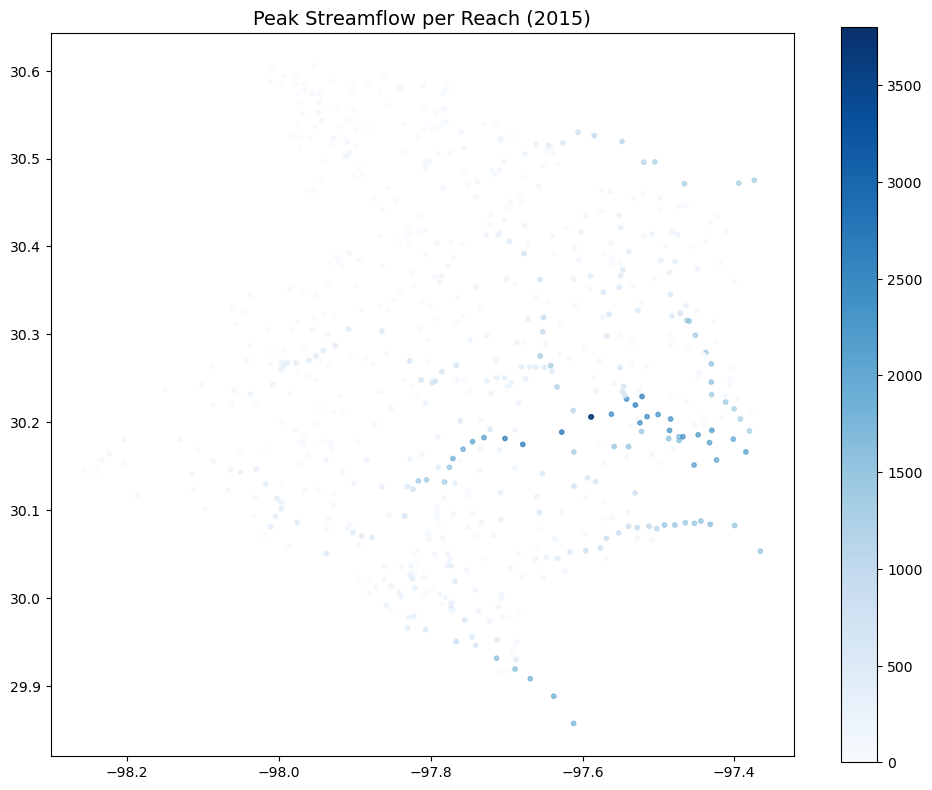

In [8]:
# 1. Drop rows with NaN streamflow
df_clean = df.dropna(subset=['streamflow'])

# 2. Get index of the peak streamflow per reach
idx = df_clean.groupby("feature_id")["streamflow"].idxmax()

# 3. Extract peak values using those indices
peak_per_reach = df_clean.loc[idx]

# 4. Create geometry from lon/lat
geometry = [Point(xy) for xy in zip(peak_per_reach["longitude"], peak_per_reach["latitude"])]

# 5. Make GeoDataFrame
gdf_peaks = gpd.GeoDataFrame(peak_per_reach, geometry=geometry, crs="EPSG:4326")

# 6. Optional: plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf_peaks.plot(
    ax=ax,
    column="streamflow",
    cmap="Blues",
    legend=True,
    markersize=10,
    alpha=0.7
)
ax.set_title("Peak Streamflow per Reach (2015)", fontsize=14)
plt.tight_layout()
plt.show()


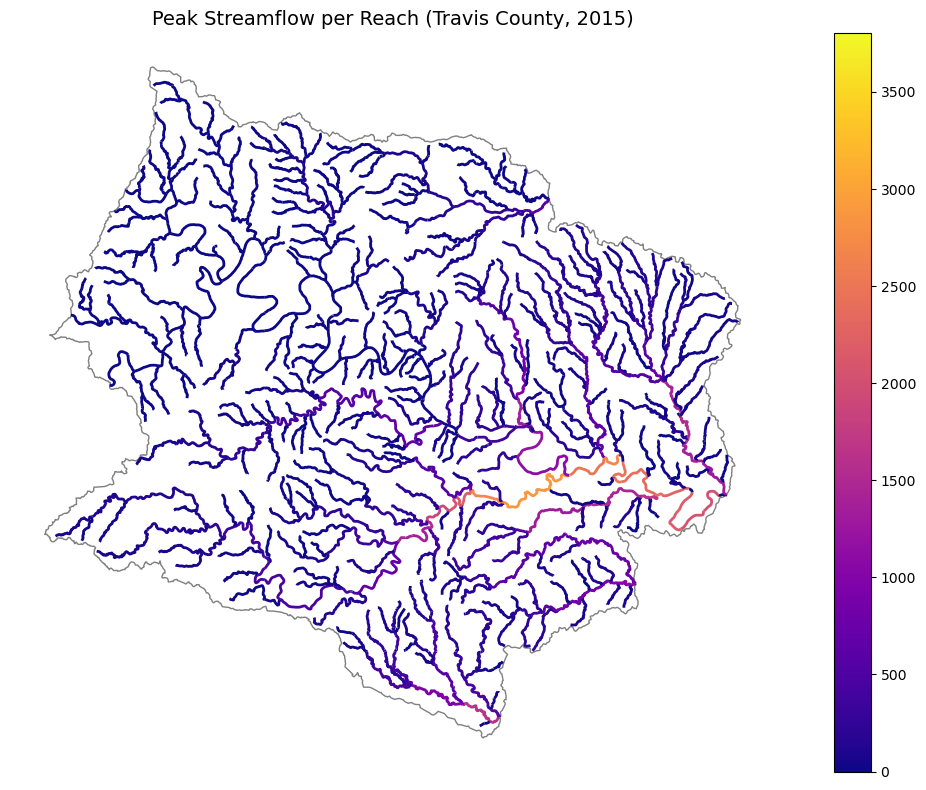

In [9]:
# Step 1: Load Travis watershed boundary
#gdb_path = "/Users/nanaoye/Documents/ArcGIS/Projects/Theme4DataRevised/Theme4Data.gdb"
gdb_path = r"C:\Users\adeba\OneDrive\Documents\ArcGIS\Projects\Theme4DataRevised\Theme4Data.gdb"
watershed = gpd.read_file(gdb_path, layer="TravisWatershedBoundary").to_crs("EPSG:4326")

# Step 2: Load flowlines layer (make sure it has a column with COMID or feature_id)
flowlines = gpd.read_file(gdb_path, layer="TravisFlowlines").to_crs("EPSG:4326")
flowlines["ID"] = flowlines["ID"].astype(int)
df["feature_id"] = df["feature_id"].astype(int)

# Step 3: Clean and get peak flow per reach (as done previously)
df_clean = df.dropna(subset=['streamflow'])
idx = df_clean.groupby("feature_id")["streamflow"].idxmax()
peak_per_reach = df_clean.loc[idx]


# Step 4: Merge peak streamflow with flowlines using COMID/feature_id
# NOTE: update 'ID' below to the actual column name in flowlines for feature_id (check: flowlines.columns)
flowlines_peaks = flowlines.merge(peak_per_reach, left_on="ID", right_on="feature_id", how = "left")

# Fill in no-data streamflow as 0 (optional, or keep as NaN)
flowlines_peaks["streamflow"] = flowlines_peaks["streamflow"].fillna(0)

# Step 5: Clip to watershed (optional, if flowlines extend beyond)
flowlines_peaks = gpd.clip(flowlines_peaks, watershed)

# Step 6: Plot peak streamflow on flowlines
fig, ax = plt.subplots(figsize=(12, 8))
watershed.boundary.plot(ax=ax, color="gray", linewidth=1)
flowlines_peaks.plot(ax=ax, column="streamflow", cmap="plasma", legend=True, linewidth=2)
ax.set_title("Peak Streamflow per Reach (Travis County, 2015)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [10]:
flowlines_peaks

,ID,to,order_,Lake,gages,Slope,Length,mainstem,Shape_Length,geometry,time,feature_id,elevation,gage_id,latitude,longitude,order,streamflow
366,1631665,1631057.0,1.0,-9999.0,,0.00586,701.0,0.0,701.198426,"LINESTRING (-97.70983 29.91333, -97.70357 29.9...",2015-05-25 23:00:00,1631665.0,153.880005,b' ',29.914932,-97.706696,1.0,20.410000
324,1631053,1631055.0,4.0,-9999.0,,0.00155,5825.0,0.0,5824.610149,"LINESTRING (-97.73295 29.9385, -97.73203 29.93...",2015-10-30 17:00:00,1631053.0,146.250000,b' ',29.931171,-97.713264,4.0,1636.279963
332,1631037,1631053.0,3.0,-9999.0,,0.00283,2657.0,0.0,2657.448992,"LINESTRING (-97.74302 29.95229, -97.74297 29.9...",2015-10-30 17:00:00,1631037.0,153.779999,b' ',29.945724,-97.740891,3.0,664.959985
349,1631041,1631049.0,2.0,-9999.0,,0.00131,6977.0,0.0,6977.148959,"LINESTRING (-97.73045 29.96848, -97.73045 29.9...",2015-05-26 00:00:00,1631041.0,146.380005,b' ',29.952070,-97.712677,2.0,453.059990
333,1631613,1631037.0,3.0,-9999.0,,0.00208,895.0,0.0,895.399460,"LINESTRING (-97.74566 29.95905, -97.74556 29.9...",2015-10-30 17:00:00,1631613.0,155.639999,b' ',29.955343,-97.745636,3.0,619.649986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,5778959,5778973.0,1.0,-9999.0,,0.01878,3852.0,0.0,3851.574010,"LINESTRING (-98.04231 30.61395, -98.04276 30.6...",NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
671,5778951,5779365.0,1.0,-9999.0,,0.01403,2490.0,0.0,2490.071395,"LINESTRING (-98.01891 30.61244, -98.01793 30.6...",2015-05-25 20:00:00,5778951.0,363.470001,b' ',30.604666,-98.010223,1.0,24.409999
653,5778939,5778961.0,1.0,-9999.0,,0.01409,5263.0,0.0,5263.377688,"LINESTRING (-98.08398 30.64145, -98.08244 30.6...",NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
631,5778945,5778961.0,2.0,-9999.0,,0.00668,7170.0,0.0,7170.492602,"LINESTRING (-98.11242 30.64411, -98.11186 30.6...",NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


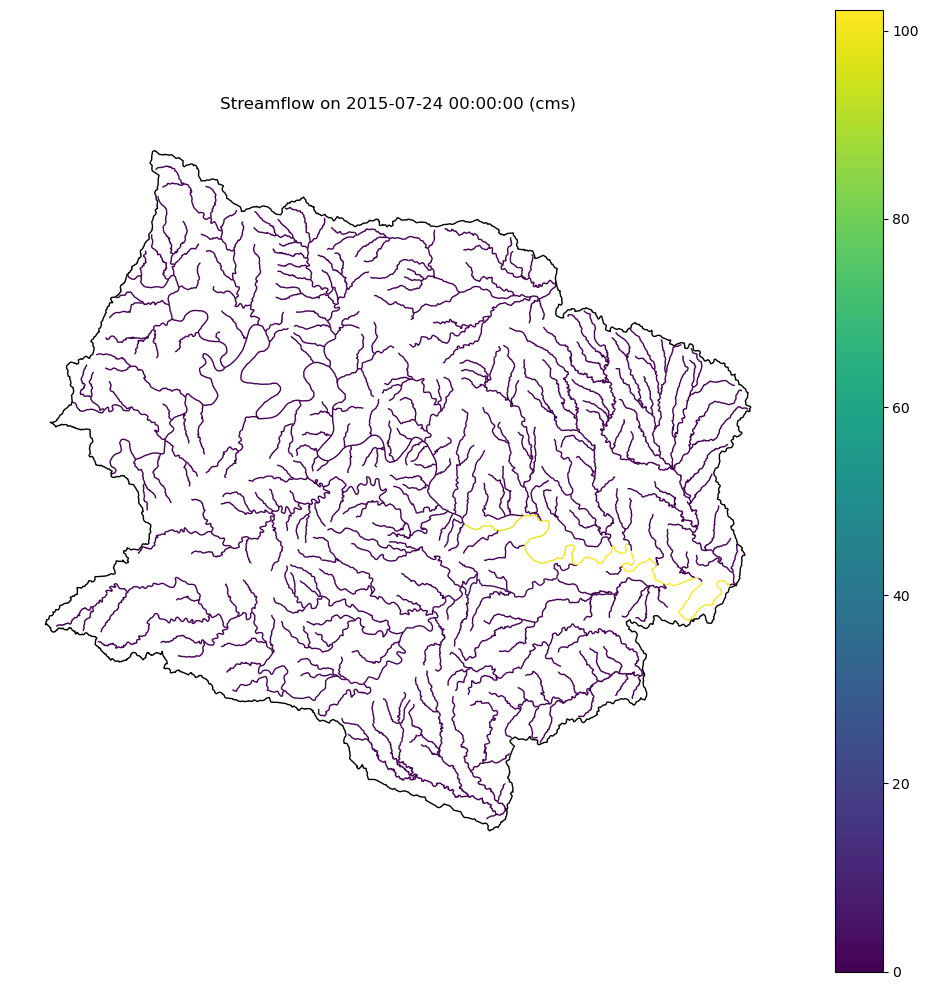

In [12]:
# --- Step 1: Filter streamflow data for a specific date ---
target_date = "2015-07-24 00:00:00"
df['time'] = pd.to_datetime(df['time'])
daily_df = df[df['time'] == target_date].copy()

# --- Step 2: Merge with flowlines using feature_id or COMID ---
# Ensure both have the same key column name if needed
flowlines = flowlines.rename(columns={'ID': 'feature_id'})  # if needed

merged = flowlines.merge(daily_df, left_on="feature_id", right_on="feature_id", how = "left")

# Fill in no-data streamflow as 0 (optional, or keep as NaN)
merged["streamflow"] = merged["streamflow"].fillna(0)

# --- Step 3: Plot the result ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column='streamflow',
            cmap='viridis',
            linewidth=1,
            legend=True,
            ax=ax)

# Optionally plot the watershed outline
watershed.boundary.plot(ax=ax, color='black', linewidth=1)

# Final touches
plt.title(f"Streamflow on {target_date} (cms)")
ax.axis('off')
plt.tight_layout()
plt.show()


In [13]:
df

,time,feature_id,elevation,gage_id,latitude,longitude,order,streamflow
0,2015-01-01 00:00:00,1630981,166.029999,b' ',29.994314,-97.772285,2,0.00
1,2015-01-01 00:00:00,1631525,166.690002,b' ',29.950016,-97.766273,3,0.29
2,2015-01-01 00:00:00,1630983,171.210007,b' ',29.994579,-97.774010,2,0.00
3,2015-01-01 00:00:00,1629567,193.660004,b' ',30.001068,-97.838654,1,0.00
4,2015-01-01 00:00:00,1631001,204.240005,b' ',29.991272,-97.858444,2,0.00
...,...,...,...,...,...,...,...,...
6456115,2015-12-31 23:00:00,1629533,194.899994,b' ',30.023439,-97.824738,2,0.00
6456116,2015-12-31 23:00:00,1629809,194.899994,b' ',30.026756,-97.827263,1,0.00
6456117,2015-12-31 23:00:00,1629523,204.720001,b' ',30.036194,-97.825897,1,0.00
6456118,2015-12-31 23:00:00,1629537,194.899994,b' ',30.021084,-97.823837,2,0.00


In [8]:
# Step 8: Save to CSV
df.to_csv("/Users/nanaoye/Library/CloudStorage/Box-Box/My Research/CUAHSI/SI_2025/streamflow_travis_2015.csv", index=False)